In [3]:
from gymnasium import Env
import gymnasium
from gymnasium.spaces import Box, Dict, Discrete, MultiDiscrete, Tuple
from ray.rllib.utils.spaces.repeated import Repeated
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

In [32]:
class Architecture:
    def __init__(self):
        self.space_flag = 0
        self.c_capacity, self.s_capacity = 1000, 100                                         # Capacity of the devices
        # self.a1, self.a2, self.a3, self.mc = 0.000125, 0.000010, 0.000200, 0.001           # Weight of every type of data
        self.weights = [0.0125, 0.0010, 0.0200, 0.1000]                                      # a1, a2, a3, mc
        self.lifetime = {'a1': 10000, 'a2': 20000, 'a3': 10000, 'mc': 1000}                  # Max lifetime of the different data types
        self.total_c = 2
        self.total_s = 6
        self.max_actions = 20

        self.devices = {}
        self.data = {
            'a1': {},
            'a2': {},
            'a3': {},
            'mc': {},
        }
        self.latencies = {}

        for i in range(self.total_c):
            for j in (self.data.keys()):
                self.data[j]['c'+str(i)] = 0
            self.devices['c'+str(i)] = {'a1': 0, 'a2': 0, 'a3': 0, 'mc': 0}
            self.latencies['c'+str(i)] = {}
        for i in range(self.total_s):
            for j in (self.data.keys()):
                self.data[j]['s'+str(i)] = 0
            self.devices['s'+str(i)] = {'a1': 0, 'a2': 0, 'a3': 0, 'mc': 0}
            self.latencies['s'+str(i)] = {}

        for i in self.latencies.keys():
            for j in self.latencies.keys():
                self.latencies[i][j] = 0

        self.data_types = []
        self.data_allocation = []
        self.data_times = []

        self.data_allocation_dict = []

        self.action_type = []
        self.action_device_dev = []
        self.action_device = []

        randomized = list(self.devices.keys())
        random.shuffle(randomized)

        bound = round(len(self.devices)/4)

        self.clusters = {
            'a1': randomized[:bound],
            'a2': randomized[bound:bound*2],
            'a3': randomized[bound*2:bound*3],
            'mc': randomized[bound*3:]
        }

        self.visualization()

    def to_int(self, device):
        return list(self.devices.keys()).index(device)

    def to_int_type(self, type):
        return list(self.data.keys()).index(type)

    def to_device(self, position):
        return list(self.devices.keys())[position]

    def construct_dictionaries(self):
        for i in self.data:
            for j in self.data[i]:
                self.data[i][j] = 0
        for i in self.devices:
            for j in self.devices[i]:
                self.devices[i][j] = 0
        for device, d_type in zip(self.data_allocation_dict,self.data_types):
            self.data[d_type][device] += 1
            self.devices[device][d_type] += 1

    def update(self, data_type, device):
        self.data_types.append(data_type)
        self.data_allocation_dict.append(device)
        self.data_allocation.append(self.to_int(device))
        self.data_times.append(0)
        self.devices[device][data_type] += 1
        self.data[data_type][device] += 1

    def heart_beat(self):
        deads = []
        for i in range(len(self.data_times)):
            self.data_times[i] += 1
            if self.data_times[i] == self.lifetime[self.data_types[i]]:
                deads.append(i)

        removed = 0
        for i in deads:
            self.devices[self.data_allocation_dict[i-removed]][self.data_types[i-removed]] -= 1
            self.data[self.data_types[i-removed]][self.data_allocation_dict[i-removed]] -= 1
            self.data_types.pop(i - removed)
            self.data_allocation_dict.pop(i - removed)
            self.data_allocation.pop(i - removed)
            self.data_times.pop(i - removed)
            removed += 1

    def free_space(self):
        load = {}
        for i in self.devices.keys():
            if list(i)[0] == 'c':
                load[i] = (self.c_capacity - sum([a*b for a,b in zip(list(self.devices[i].values()), self.weights)]))/self.c_capacity
            else:
                load[i] = (self.s_capacity - sum([a*b for a,b in zip(list(self.devices[i].values()), self.weights)]))/self.s_capacity
            if load[i] <= 0.2:
                self.space_flag = i
        return load

    def visualization(self):
        keys = list(self.devices.keys())
        cs = keys[:self.total_c]
        ss = keys[self.total_c:]

        colors = []
        sizes = []

        graph = nx.Graph()

        colors.append('lightblue')
        sizes.append(1000)
        index = 0
        for i in range(len(cs)):
            if i != len(cs)-1:
                colors.append('lightblue')
                sizes.append(1000)
                graph.add_edge(cs[i],cs[i+1])
                graph.add_weighted_edges_from([(cs[i],cs[i+1],10)])
                for j in range(int(len(ss)/self.total_c)):
                    colors.append('orange')
                    sizes.append(100)
                    graph.add_edge(cs[i],ss[index])
                    graph.add_weighted_edges_from([(cs[i],ss[index],4)])
                    index += 1
            else:
                graph.add_edge(cs[i],cs[0])
                graph.add_weighted_edges_from([(cs[i],cs[0],10)])
                for j in range(int(len(ss)/self.total_c)+len(ss)%self.total_c):
                    graph.add_edge(cs[i],ss[index])
                    graph.add_weighted_edges_from([(cs[i],ss[index],4)])
                    colors.append('orange')
                    sizes.append(100)
                    index += 1

        pos = nx.spring_layout(graph)  # Position nodes using a spring layout algorithm
        # nx.draw(graph, pos, with_labels=True, node_size=sizes, node_color=colors, font_weight=12, font_color='black', edge_color='gray')
        edge_labels = nx.get_edge_attributes(graph, 'weight')
        # nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

        # plt.title("Architecture:")
        # plt.axis('off')
        # plt.show()

        for u in graph.nodes:
            shortest_paths = nx.shortest_path_length(graph, source=u, weight='weight')
            for v, weight in shortest_paths.items():
                self.latencies[u][v] = weight

    def compute_total_latency(self):
        total_latency = 0
        for i in range(len(self.action_type)):
            total_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.latencies[self.action_device_dev[i]].values())])
        return total_latency

    def generate(self, operation):
        if operation == 'a1' or operation == 'a2' or operation == 'a3':
            for i in self.devices.keys():
                self.update(operation,i)
        elif operation == 'mc':
            for i in self.devices.keys():
                if list(i)[0] == 's':
                    self.update('mc',i)
        elif operation.split('_')[0] == 'ai':
            device=random.sample(list(self.clusters[operation.split('_')[1]]),1)
            self.action_device_dev.append(device[0])
            self.action_device.append(self.to_int(device[0]))
            self.action_type.append(operation.split('_')[1])
            difference = len(self.action_device_dev) - self.max_actions
            if difference >= 0:
                for i in range(difference):
                    self.action_device_dev.pop(0)
                    self.action_device.pop(0)
                    self.action_type.pop(0)

    def rl_update(self, allocation):
        allocation_dict = []
        for i in allocation:
            allocation_dict.append(self.to_device(i))
        self.data_allocation = allocation
        self.data_allocation_dict = allocation_dict
        self.construct_dictionaries()
        return self.free_space()

    def greedy_algorithm(self): # baseline?
        if self.space_flag == 0:
            allocation = []
            allocation_dev = []
            for i in self.data_types:
                allocation.append(self.to_int(random.sample(list(self.clusters[i]),1)[0]))
                allocation_dev.append(random.sample(list(self.clusters[i]),1)[0])
            self.data_allocation = allocation
            self.data_allocation_dict = allocation_dev
            self.construct_dictionaries()
            result = self.free_space()
        else:
            problematic_key = None
            for key, value in self.clusters.items():
                if self.space_flag in value:
                    problematic_key = key
                    break
            self.clusters[problematic_key].extend(element for element in self.devices if element[0]==('c'))
            self.space_flag = 0
            result = self.greedy_algorithm()

        return result

In [28]:
class SimulatedArchitecture(Env):
    def __init__(self):
        self.architecture = Architecture()
        self.executions = ['a1','a2','mc','a1','ai_a2','mc','a3','ai_a1','mc','a1','ai_a3','mc','a2','a3','ai_a2','mc','ai_a1','a1','mc','ai_a3','ai_mc']

        self.num_devices = len(self.architecture.devices.keys())
        self.observation_space = Dict({
            # "action_mask": Box(0, self.num_devices, shape=(max_avail_actions, ), dtype=np.int32),
            "weights": Box(low=0, high=1, shape=(4,), dtype=np.float32),
            "free_space": Box(low=0, high=1, shape=(self.num_devices,), dtype=np.float32),
            "allocation": Repeated(Discrete(4), 5)
        })
        self.action_space = Tuple((Box(low=0, high=1, shape=(2,), dtype=np.float32),Discrete(1)))

        self.weights = np.array(self.architecture.weights, dtype=np.float32)
        self.free_space = np.array(list(self.architecture.free_space().values()), dtype=np.float32)
    def get_obs(self):
        return {
            "weights": self.weights,
            "free_space": self.free_space,
            "allocation": self.observation_space["allocation"].sample()
        }
    def step(self, action):
        print(action)
        self.length = random.randint(0,5)
        reward = 1
        done = True
        info = {}
        return self.get_obs(), reward, done, info
    def render(self):
        pass
    def reset(self):
        self.action_space = Tuple((Box(low=0, high=1, shape=(10,), dtype=np.float32),Discrete(1)))
        # self.action_space = Box(0, self.num_devices, shape=(random.randint(1,5), ), dtype=np.int32)
        return self.get_obs()
    def close(self):
        pass

In [29]:
simulation = SimulatedArchitecture()
# for i in range(5):
#     print(simulation.observation_space.sample())
#     simulation.reset()
#     simulation.step(simulation.action_space.sample())
print(simulation.action_space.sample())
simulation.reset()
print(simulation.action_space.sample())

(array([0.24810933, 0.23443152], dtype=float32), 0)
(array([0.6265255 , 0.01530288, 0.6290112 , 0.6904504 , 0.2261503 ,
       0.39107797, 0.1684374 , 0.09549104, 0.1496204 , 0.70483094],
      dtype=float32), 0)


In [30]:
from ray.tune.registry import register_env
from gymnasium.wrappers import EnvCompatibility
from ray.rllib.algorithms.ppo import PPOConfig
from gymnasium.wrappers import TimeLimit
import ray

def env_creator(env_config):
    return TimeLimit(EnvCompatibility(SimulatedArchitecture()), max_episode_steps=10)
register_env("ACES", env_creator)

config = (
    PPOConfig()
    .environment("ACES",disable_env_checking=True)
    .framework("torch")
    .rollouts(num_rollout_workers=1,
              num_envs_per_worker=1) # Max = 60
    .resources(num_gpus=0,
               num_cpus_per_worker=1)
    .training(entropy_coeff=0.02)
)

algorithm = config.build()

for i in tqdm(range(3)):
    algorithm.train()

2023-05-31 17:41:09,597	WARNING util.py:67 -- Install gputil for GPU system monitoring.
  0%|                                                                                                                           | 0/3 [00:00<?, ?it/s]

(RolloutWorker pid=1148102) (array([0.12151152, 0.34698713], dtype=float32), 0)
(RolloutWorker pid=1148102) (array([1., 1.], dtype=float32), 0)
(RolloutWorker pid=1148102) (array([0.3172355, 1.       ], dtype=float32), 0)
(RolloutWorker pid=1148102) (array([0.5633605, 0.       ], dtype=float32), 0)
(RolloutWorker pid=1148102) (array([0.04510936, 0.7328065 ], dtype=float32), 0)
(RolloutWorker pid=1148102) (array([1., 1.], dtype=float32), 0)
(RolloutWorker pid=1148102) (array([0.47753993, 0.24093029], dtype=float32), 0)
(RolloutWorker pid=1148102) (array([0.9665103, 0.7734945], dtype=float32), 0)
(RolloutWorker pid=1148102) (array([0.57291776, 0.0629358 ], dtype=float32), 0)
(RolloutWorker pid=1148102) (array([0.30777374, 0.10024071], dtype=float32), 0)
(RolloutWorker pid=1148102) (array([0.80575436, 0.        ], dtype=float32), 0)
(RolloutWorker pid=1148102) (array([0., 1.], dtype=float32), 0)
(RolloutWorker pid=1148102) (array([0.67981833, 0.46785024], dtype=float32), 0)
(RolloutWorker

 33%|██████████████████████████████████████▎                                                                            | 1/3 [00:19<00:38, 19.33s/it]

(RolloutWorker pid=1148102) (array([0.11579102, 0.36770535], dtype=float32), 0)
(RolloutWorker pid=1148102) (array([0.4511677, 0.0169808], dtype=float32), 0)
(RolloutWorker pid=1148102) (array([0.72097313, 0.5624326 ], dtype=float32), 0)
(RolloutWorker pid=1148102) (array([1., 1.], dtype=float32), 0)
(RolloutWorker pid=1148102) (array([0.69723594, 0.79343   ], dtype=float32), 0)
(RolloutWorker pid=1148102) (array([0.43414587, 1.        ], dtype=float32), 0)
(RolloutWorker pid=1148102) (array([0.96890414, 0.6995577 ], dtype=float32), 0)
(RolloutWorker pid=1148102) (array([0.6917289 , 0.97540045], dtype=float32), 0)
(RolloutWorker pid=1148102) (array([0., 0.], dtype=float32), 0)
(RolloutWorker pid=1148102) (array([0.08194268, 0.78716743], dtype=float32), 0)
(RolloutWorker pid=1148102) (array([0.75193584, 0.        ], dtype=float32), 0)
(RolloutWorker pid=1148102) (array([0.44702488, 0.3022635 ], dtype=float32), 0)
(RolloutWorker pid=1148102) (array([0.        , 0.92724663], dtype=float32

 67%|████████████████████████████████████████████████████████████████████████████▋                                      | 2/3 [00:37<00:18, 18.82s/it]

(RolloutWorker pid=1148102) (array([0.7297218, 0.       ], dtype=float32), 0)
(RolloutWorker pid=1148102) (array([0.14146566, 0.5351989 ], dtype=float32), 0)
(RolloutWorker pid=1148102) (array([0.1837281, 1.       ], dtype=float32), 0)
(RolloutWorker pid=1148102) (array([1.       , 0.7809636], dtype=float32), 0)
(RolloutWorker pid=1148102) (array([0.57053244, 0.56515217], dtype=float32), 0)
(RolloutWorker pid=1148102) (array([0.50698066, 0.        ], dtype=float32), 0)
(RolloutWorker pid=1148102) (array([0.11243939, 0.6705893 ], dtype=float32), 0)
(RolloutWorker pid=1148102) (array([0.14011765, 0.8519641 ], dtype=float32), 0)
(RolloutWorker pid=1148102) (array([0.46969748, 1.        ], dtype=float32), 0)
(RolloutWorker pid=1148102) (array([0.21012694, 0.36511844], dtype=float32), 0)
(RolloutWorker pid=1148102) (array([0.5816479 , 0.14901173], dtype=float32), 0)
(RolloutWorker pid=1148102) (array([0.73839885, 0.7833271 ], dtype=float32), 0)
(RolloutWorker pid=1148102) (array([0.35500222

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:56<00:00, 18.77s/it]


In [104]:
class OfflineTesting(Env):
    def __init__(self):
        self.observation_space = Box(low=0, high=1, shape=(5,), dtype=np.int32)
        self.action_space = Discrete(2)
        self.observation = []
    def step(self, action):
        if np.sum(self.observation) % 2 == 0:
            if action == 0:
                reward = 1
            else:
                reward = 0
        else:
            if action == 0:
                reward = 0
            else:
                reward = 1
        done = True
        info = {}

        return self.observation, reward, done, info
    def render(self):
        pass
    def reset(self):
        self.observation = self.observation_space.sample()
        return self.observation
    def close(self):
        pass

In [100]:
testEnv = OfflineTesting()
testEnv.action_space.sample()

1

In [106]:
from ray.tune.registry import register_env
from gymnasium.wrappers import EnvCompatibility
from ray.rllib.algorithms.ppo import PPOConfig
from gymnasium.wrappers import TimeLimit
import ray

def env_creator(env_config):
    return TimeLimit(EnvCompatibility(OfflineTesting()), max_episode_steps=10)
register_env("OfflineTest", env_creator)

config = (
    PPOConfig()
    .environment("OfflineTest",disable_env_checking=True)
    # .framework("torch")
    .rollouts(num_rollout_workers=10,
              num_envs_per_worker=5) # Max = 60
    .resources(num_gpus=0,
               num_cpus_per_worker=1)
    .training(entropy_coeff=0.02)
)
config['model']['vf_share_layers'] = False
config["model"]["fcnet_hiddens"] =[32,32]

# algorithm = config.build()

# result = []
# for i in tqdm(range(10)):
#     result.append(algorithm.train()["episode_reward_mean"])
#     print(result)

algorithm2 = config.build()
# algorithm2.set_weights(algorithm.get_weights())
# checkpoint_path = algorithm2.save()
# algorithm2 = config.build()
# algorithm2.restore(checkpoint_path)

result2 =[]
for i in tqdm(range(10)):
    result2.append(algorithm2.train()["episode_reward_mean"])
    print(result2)

2023-06-02 10:19:05,433	WARNING util.py:67 -- Install gputil for GPU system monitoring.
 10%|███████████▍                                                                                                      | 1/10 [00:04<00:39,  4.36s/it]

[0.50475]


 20%|██████████████████████▊                                                                                           | 2/10 [00:08<00:34,  4.29s/it]

[0.50475, 0.49775]


 20%|██████████████████████▊                                                                                           | 2/10 [00:11<00:45,  5.71s/it]


KeyboardInterrupt: 

In [200]:
print(result2)

[0.612, 0.63825, 0.6605, 0.7185, 0.75225, 0.76725, 0.825, 0.85075, 0.8525, 0.87125]


In [135]:
offline_test_dataset = {
    "observations": [],
    "actions": [],
    "rewards": [],
    "next_observations": []
}

import os
import json
file_path = "/tmp/offline_test.json"
# os.remove(file_path)

# f = open(file_path, "x")

for i in range(5):
    observation = testEnv.observation_space.sample()
    action = testEnv.action_space.sample()
    if np.sum(observation) % 2 == 0:
        if action == 0:
            reward = 1
        else:
            reward = 0
    else:
        if action == 0:
            reward = 0
        else:
            reward = 1
    line = {}
    line["observations"] = []
    line["observations"].append(observation.tolist())
    line["actions"] = []
    line["actions"].append(action)
    line["rewards"] = []
    line["rewards"].append(reward)
    line["dones"] = []
    line["dones"].append(True)
    line["infos"] = []
    line["infos"].append({})
    line["next_observations"] = []
    line["next_observations"].append(observation.tolist())
    with open(file_path, "a") as file:
        json.dump(line,file)

In [15]:
with open("/tmp/invent", "a") as file:
    file.write("hola")
with open("/tmp/invent", "r") as file:
    a=file.read()
    print(a)

holaholahola


In [179]:
from ray.rllib.algorithms.bc import BCConfig
import ray
from ray.tune.registry import register_env
from gymnasium.wrappers import EnvCompatibility
from gymnasium.wrappers import TimeLimit
from ray.rllib.utils.test_utils import check_train_results

ray.shutdown()

def env_creator(env_config):
    return TimeLimit(EnvCompatibility(OfflineTesting()), max_episode_steps=10)
register_env("OfflineTest", env_creator)
path = "/tmp/demo-out/one_million"

config = (
    BCConfig()
    .environment(env="OfflineTest",disable_env_checking=True)
    .offline_data(input_=path)
    .training(
        train_batch_size=2,
        # twin_q=False,
    )
    .evaluation(
        evaluation_interval=5,
        evaluation_num_workers=1,
        evaluation_duration=5,
        evaluation_parallel_to_training=True,
        evaluation_config=BCConfig.overrides(input_="sampler"),
    )
    .rollouts(num_rollout_workers=1)
)
config['model']['vf_share_layers'] = False
config["model"]["fcnet_hiddens"] = [64,64]

algorithm_bc = config.build()
for i in tqdm(range(20000)):
    result = algorithm_bc.train()
    check_train_results(result)
    # print(result)
    eval_results = result.get("evaluation")
    # if eval_results:
    #     print("iter={} R={}".format(i, eval_results["episode_reward_mean"]))

2023-06-02 12:15:52,092	WARNING deprecation.py:50 -- DeprecationWarning: `MARWIL used to have off_policy_estimation_methods is and wis by default. This haschanged to off_policy_estimation_methods: \{\}.If you want to use an off-policy estimator, specify it in.evaluation(off_policy_estimation_methods=...)` has been deprecated. This will raise an error in the future!
2023-06-02 12:15:54,637	INFO worker.py:1553 -- Started a local Ray instance.
(RolloutWorker pid=2449739) 2023-06-02 12:16:04,205	WARNING json_reader.py:261 -- Treating input directory as glob patterns: ['/tmp/demo-out/one_million/*.json', '/tmp/demo-out/one_million/*.zip']
2023-06-02 12:16:04,799	WARNING json_reader.py:261 -- Treating input directory as glob patterns: ['/tmp/demo-out/one_million/*.json', '/tmp/demo-out/one_million/*.zip']
2023-06-02 12:16:11,820	INFO trainable.py:172 -- Trainable.setup took 19.722 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation ov

In [204]:
from ray.rllib.algorithms.bc import BCConfig
import ray
from ray.tune.registry import register_env
from gymnasium.wrappers import EnvCompatibility
from gymnasium.wrappers import TimeLimit
from ray.rllib.utils.test_utils import check_train_results

ray.shutdown()

def env_creator(env_config):
    return TimeLimit(EnvCompatibility(OfflineTesting()), max_episode_steps=10)
register_env("OfflineTest", env_creator)
path = "/tmp/demo-out/output-2023-06-02_12-59-54_worker-0_0.json"

config2 = (
    BCConfig()
    .environment(env="OfflineTest",disable_env_checking=True)
    .offline_data(input_=path)
    .training(
        train_batch_size=2,
        # twin_q=False,
    )
    .evaluation(
        evaluation_interval=5,
        evaluation_num_workers=1,
        evaluation_duration=5,
        evaluation_parallel_to_training=True,
        evaluation_config=BCConfig.overrides(input_="sampler"),
    )
    .rollouts(num_rollout_workers=1)
)
config2['model']['vf_share_layers'] = False
config2["model"]["fcnet_hiddens"] = [64,64]

algorithm_bc2 = config2.build()
for i in tqdm(range(2000)):
    result = algorithm_bc2.train()
    check_train_results(result)
    # print(result)
    eval_results = result.get("evaluation")

2023-06-02 13:03:54,814	WARNING deprecation.py:50 -- DeprecationWarning: `MARWIL used to have off_policy_estimation_methods is and wis by default. This haschanged to off_policy_estimation_methods: \{\}.If you want to use an off-policy estimator, specify it in.evaluation(off_policy_estimation_methods=...)` has been deprecated. This will raise an error in the future!
2023-06-02 13:03:56,365	INFO worker.py:1553 -- Started a local Ray instance.
2023-06-02 13:04:10,369	INFO trainable.py:172 -- Trainable.setup took 15.547 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-06-02 13:04:10,370	WARNING util.py:67 -- Install gputil for GPU system monitoring.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:50<00:00, 39.60it/s]


In [208]:
from ray.tune.registry import register_env
from gymnasium.wrappers import EnvCompatibility
from ray.rllib.algorithms.ppo import PPOConfig
from gymnasium.wrappers import TimeLimit
import ray

ray.shutdown()

def env_creator(env_config):
    return TimeLimit(EnvCompatibility(OfflineTesting()), max_episode_steps=10)
register_env("OfflineTest", env_creator)

config = (
    PPOConfig()
    .environment("OfflineTest",disable_env_checking=True)
    .rollouts(num_rollout_workers=10,
              num_envs_per_worker=5) # Max = 60
    .resources(num_gpus=0,
               num_cpus_per_worker=1)
    .training(entropy_coeff=0.02)
)
config['model']['vf_share_layers'] = False
config["model"]["fcnet_hiddens"] =[64,64]

algorithm = config.build()
algorithm.set_weights(algorithm_bc2.get_weights())
checkpoint_path = algorithm.save()
print(checkpoint_path)
algorithm = config.build()
algorithm.restore(checkpoint_path)

result =[]
for i in tqdm(range(10)):
    result.append(algorithm.train()["episode_reward_mean"])
    print(result)

2023-06-02 13:08:00,284	INFO worker.py:1553 -- Started a local Ray instance.
2023-06-02 13:08:10,635	INFO trainable.py:172 -- Trainable.setup took 12.773 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-06-02 13:08:10,660	WARNING util.py:67 -- Install gputil for GPU system monitoring.


/home/rcalzada/ray_results/PPO_OfflineTest_2023-06-02_13-07-57ici2i56v/checkpoint_000000


2023-06-02 13:08:18,715	WARNING util.py:67 -- Install gputil for GPU system monitoring.
2023-06-02 13:08:18,930	INFO trainable.py:791 -- Restored on 138.4.11.227 from checkpoint: /home/rcalzada/ray_results/PPO_OfflineTest_2023-06-02_13-07-57ici2i56v/checkpoint_000000
2023-06-02 13:08:18,931	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': None, '_time_total': 0.0, '_episodes_total': None}
 10%|███████████▍                                                                                                      | 1/10 [00:02<00:26,  2.99s/it]

[0.507]


 20%|██████████████████████▊                                                                                           | 2/10 [00:06<00:24,  3.11s/it]

[0.507, 0.5165]


 30%|██████████████████████████████████▏                                                                               | 3/10 [00:09<00:22,  3.28s/it]

[0.507, 0.5165, 0.517]


 40%|█████████████████████████████████████████████▌                                                                    | 4/10 [00:12<00:18,  3.14s/it]

[0.507, 0.5165, 0.517, 0.536]


 50%|█████████████████████████████████████████████████████████                                                         | 5/10 [00:15<00:14,  2.94s/it]

[0.507, 0.5165, 0.517, 0.536, 0.6075]


 60%|████████████████████████████████████████████████████████████████████▍                                             | 6/10 [00:18<00:12,  3.01s/it]

[0.507, 0.5165, 0.517, 0.536, 0.6075, 0.67725]


 70%|███████████████████████████████████████████████████████████████████████████████▊                                  | 7/10 [00:20<00:08,  2.86s/it]

[0.507, 0.5165, 0.517, 0.536, 0.6075, 0.67725, 0.7475]


 80%|███████████████████████████████████████████████████████████████████████████████████████████▏                      | 8/10 [00:23<00:05,  2.73s/it]

[0.507, 0.5165, 0.517, 0.536, 0.6075, 0.67725, 0.7475, 0.814]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 9/10 [00:26<00:02,  2.73s/it]

[0.507, 0.5165, 0.517, 0.536, 0.6075, 0.67725, 0.7475, 0.814, 0.855]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.96s/it]

[0.507, 0.5165, 0.517, 0.536, 0.6075, 0.67725, 0.7475, 0.814, 0.855, 0.908]


In [32]:
def env_creator(env_config):
    return TimeLimit(EnvCompatibility(OfflineTesting()), max_episode_steps=10)
register_env("OfflineTest", env_creator)

config = (
    PPOConfig()
    .environment("OfflineTest",disable_env_checking=True)
    # .framework("torch")
    .rollouts(num_rollout_workers=10,
              num_envs_per_worker=5) # Max = 60
    .resources(num_gpus=0,
               num_cpus_per_worker=1)
    # .offline_data(input_=offline_test_dataset)
    .offline_data(output="/tmp/test-output20")
    # .exploration(explore=False)
)
config["model"]["fcnet_hiddens"] =[64,64]

algorithm_output = config.build()

for i in range(20):
    result = algorithm_output.train()
    print(result["episode_reward_mean"])

2023-06-01 16:31:10,495	WARNING util.py:67 -- Install gputil for GPU system monitoring.


0.4985
0.498
0.49875
0.53
0.56825
0.6375
0.727
0.79075
0.849
0.89375
0.9325
0.95575
0.9655
0.97375
0.9825
0.987
0.988
0.9885
0.99325
0.99575


In [73]:
file_path="/tmp/test-out/output-2023-06-01_11-19-13_worker-1_0.json"

with open(file_path, "r") as file:
    contents = file.read()
    print(contents)

{"type": "MultiAgentBatch", "count": 400, "policy_batches": {"default_policy": {"obs": "BCJNGGhAQUUAAAAAAAActBQAAGGABZU2RQABAPEajBJudW1weS5jb3JlLm51bWVyaWOUjAtfZnJvbWJ1ZmZlcpSTlCiWwEQuAAACABBABQBCAACAPwQADwIACSqgQCQADDQACBAAH0BYAAQAJAAMAgAAWAAAAgAAHAAABAAEAgAEDAAICAAILAAAAgAAHAAABAAEAgAADAAABAAAAgAMCAAPAgAJF4DcAAQ4AAACAAQMAAQIAAACAAgsAAACAAQcAAwIAAACAA8UAAEPAgAGBzQBAAIABDwADwIAAg+wAAQPAgABADQBBEwADwgAHQ8CAAoPsAAYABACD3wABQwCAA9gAQEEPAAAAgAIDAAPWAAaED8+AApAAA8CAAUPNAEBAAIAAHwAAAQABAIAAQwAD4wBGAAwAAAEAA8CABEEKAAECAAPAgAJCAgBAAIABDQABAgACAIAACwAAAIAABwAAAQABAIACAwABAIAABQAAAQADwIAEQ+4AQkNRAAPPAIYADwAAAQADwIAEQC4AQACAAQwAAgIAAgMAAACAA8IAQEEJAAMAgAPWAAJAAIAADgAAAQAAAIADAgADwIACQCEAAQwAAACAAAMAAAEAA8CAAEAGAAABAAPAgASB2ABDzQADQCEAAACAAAoAAAEAAQCAAgMAAQCAAgIAQQgAAQIAAACAAQMAAEIAA+EACwBRAAPAgAAD2gCAQACAAAwAAAEAAgCAAQQAAQIAA8CAAkIWAAIMAAEDAAECAAAAgAINAEAAgAAHAAABAAPAgABADQBBBwADwgABQACAAEcAAdMBAACAAEUAA8CAAQAsAAAAgAAJAAABAAAAgAMCAAEAgAIhAAAAgAMKAAIEAAADAAABAAPAgASD7AAHARYAAQIAAACAAAMAAAEAAgCAADc

In [74]:
!ls -l /tmp/testing/cartpole

total 16
-rw-r--r-- 1 rcalzada rcalzada  41 Jun  2 09:59 output-2023-06-02_09-59-32_worker-0_0.json
-rw-r--r-- 1 rcalzada rcalzada  41 Jun  2 09:59 output-2023-06-02_09-59-49_worker-0_0.json
-rw-r--r-- 1 rcalzada rcalzada  82 Jun  2 10:00 output-2023-06-02_10-00-02_worker-0_0.json
-rw-r--r-- 1 rcalzada rcalzada 410 Jun  2 10:02 output-2023-06-02_10-02-22_worker-0_0.json


In [199]:
"""Simple example of writing experiences to a file using JsonWriter."""

# __sphinx_doc_begin__
import gymnasium as gym
import numpy as np
import os

import ray._private.utils

from ray.rllib.models.preprocessors import get_preprocessor
from ray.rllib.evaluation.sample_batch_builder import SampleBatchBuilder
from ray.rllib.offline.json_writer import JsonWriter

if __name__ == "__main__":
    batch_builder = SampleBatchBuilder()  # or MultiAgentSampleBatchBuilder
    writer = JsonWriter(
        os.path.join(ray._private.utils.get_user_temp_dir(), "demo-out")
    )

    # You normally wouldn't want to manually create sample batches if a
    # simulator is available, but let's do it anyways for example purposes:
    env = OfflineTesting()

    # RLlib uses preprocessors to implement transforms such as one-hot encoding
    # and flattening of tuple and dict observations. For CartPole a no-op
    # preprocessor is used, but this may be relevant for more complex envs.
    prep = get_preprocessor(env.observation_space)(env.observation_space)
    print("The preprocessor is", prep)

    for eps_id in tqdm(range(10000)):
        obs, info = env.reset(), {}
        prev_action = np.zeros_like(env.action_space.sample())
        prev_reward = 0
        terminated = truncated = False
        t = 0
        while not terminated and not truncated:
            # action = env.action_space.sample()
            action = algorithm.compute_single_action(obs)
            new_obs, rew, terminated, info = env.step(action)
            batch_builder.add_values(
                t=t,
                eps_id=eps_id,
                agent_index=0,
                obs=prep.transform(obs),
                actions=action,
                action_prob=0.5,  # put the true action probability here
                action_logp=np.log(0.5),
                rewards=rew,
                prev_actions=prev_action,
                prev_rewards=prev_reward,
                terminateds=terminated,
                truncateds=truncated,
                infos=info,
                new_obs=prep.transform(new_obs)
            )
            obs = new_obs
            prev_action = action
            prev_reward = rew
            t += 1
        writer.write(batch_builder.build_and_reset())
# __sphinx_doc_end__

The preprocessor is <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f81a0a22e90>


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:17<00:00, 587.50it/s]


In [197]:
np.log(0.5)

-0.6931471805599453

In [157]:
for i in range(11):
    print("output-2023-06-02_11-38-25_worker-0_"+str(i)+".json")

output-2023-06-02_11-38-25_worker-0_0.json
output-2023-06-02_11-38-25_worker-0_1.json
output-2023-06-02_11-38-25_worker-0_2.json
output-2023-06-02_11-38-25_worker-0_3.json
output-2023-06-02_11-38-25_worker-0_4.json
output-2023-06-02_11-38-25_worker-0_5.json
output-2023-06-02_11-38-25_worker-0_6.json
output-2023-06-02_11-38-25_worker-0_7.json
output-2023-06-02_11-38-25_worker-0_8.json
output-2023-06-02_11-38-25_worker-0_9.json
output-2023-06-02_11-38-25_worker-0_10.json


In [200]:
!ls -lh /tmp/demo-out/
# !mv /tmp/demo-out/output-2023-06-02_11-49-55_worker-0_5.json /tmp/demo-out/output-2023-06-02_11-52-11_worker-0_6.json /tmp/demo-out/output-2023-06-02_11-54-17_worker-0_7.json /tmp/demo-out/output-2023-06-02_11-56-20_worker-0_8.json /tmp/demo-out/output-2023-06-02_11-58-29_worker-0_9.json /tmp/demo-out/output-2023-06-02_12-00-34_worker-0_10.json /tmp/demo-out/one_million/
# !ls -lh /tmp/test-output20
# !ls -lh /tmp/demo-out/one_million

total 37M
drwxr-xr-x 2 rcalzada rcalzada  260 Jun  2 12:12 one_million
-rw-r--r-- 1 rcalzada rcalzada 256K Jun  1 15:58 output-2023-06-01_15-58-56_worker-0_0.json
-rw-r--r-- 1 rcalzada rcalzada 290K Jun  2 10:05 output-2023-06-02_10-05-43_worker-0_0.json
-rw-r--r-- 1 rcalzada rcalzada 2.8K Jun  2 10:10 output-2023-06-02_10-10-58_worker-0_0.json
-rw-r--r-- 1 rcalzada rcalzada 4.3K Jun  2 10:15 output-2023-06-02_10-15-10_worker-0_0.json
-rw-r--r-- 1 rcalzada rcalzada 1.4K Jun  2 10:23 output-2023-06-02_10-23-33_worker-0_0.json
-rw-r--r-- 1 rcalzada rcalzada 1.4K Jun  2 11:30 output-2023-06-02_11-30-56_worker-0_0.json
-rw-r--r-- 1 rcalzada rcalzada 1.4K Jun  2 11:31 output-2023-06-02_11-31-00_worker-0_0.json
-rw-r--r-- 1 rcalzada rcalzada 1.4M Jun  2 11:31 output-2023-06-02_11-31-23_worker-0_0.json
-rw-r--r-- 1 rcalzada rcalzada 1.4M Jun  2 11:31 output-2023-06-02_11-31-27_worker-0_0.json
-rw-r--r-- 1 rcalzada rcalzada 2.8M Jun  2 11:34 output-2023-06-02_11-34-47_worker-0_0.json
-rw-r--r-

In [193]:
cartopole_path="/tmp/test-output20/output-2023-06-01_16-31-11_worker-4_0.json"
with open(cartopole_path, "r") as file:
    contents = file.read()
    print(contents)

{"type": "MultiAgentBatch", "count": 400, "policy_batches": {"default_policy": {"obs": "BCJNGGhAwR8AAAAAAACiXAwAAGGABZW2HwABAPMZjBJudW1weS5jb3JlLm51bWVyaWOUjAtfZnJvbWJ1ZmZlcpSTlCiWQC8AEwEEAAQCAAAQAAACAA8IAAEAFAAEBAAAAgAMDAAEAgAAGAAAAgAACAAABAAAAgAACAAIBAAIAgAAGAAPAgAJACAAAAQAAAIABAgAAAIAAAwAAAQADwIAAQAYAAgEAAACAAAQAAACAAAIAAwEAA8CAAEAJAAEAgAADAAABAAAAgAECAAEAgAEEAAACAAABAAAAgAACAAABAAAAgAICAAEDAAEAgAAEAAABAAIAgAEEAAMCAAIAgAAHAAIBAAIAgAAGAAMAgAPFAABCAIADyAAAQ8UAAEAAgAMGAAEEAAECAAAAgAADAAABAAPAgABABgAAAQACAIABBAAAAgAAAQAAAIAAAgADwQABQACAAgcAA8CAAEAIAAPAgABCBgABAwAAAgAAAQAAAIADwgACQgcAAQMAA8CAAUAIAAABAAEAgAEDAAACAAABAAEAgAEDAAMCAAAAgAAFAAIBAAEAgAAFAAEAgAEDAAECAAAAgAADAAEBAAAAgAIDAAEAgAAFAAEAgAADAAMBAAMAgAAIAAPAgABABgACAQAAAIAABAADAIADxQABQAYAAgEAAgCAAAYAAACAAgIAAQMAAQCAAAQAAAEAAACAAAIAA8EAAEEAgAAHAAAAgAECAAAAgAEDAAECAAEAgAIEAAADAAABAAEAgAEDAAICAAPDAAVBCgAAAIAAAwAAAQACAIABBAAAAgAAAQABAIAAAwAAAQAAAIAAAgAAAQABAIADAwAABAAAAQAAAIADwgAAQAUAAAEAAQCAAQMAAAIAAgEAAACAAQQAAgCAAAUAAACAAQIAAQCAAAQAA8E

In [49]:
class Comparison(Env):
    def __init__(self):
        # self.observation_space = Dict({
        #     "allocation": Box(low=0, high=3, shape=(5,), dtype=np.int32),
        #     "type": Box(low=0, high=7, shape=(5,), dtype=np.int32)
        # })
        self.observation_space = Box(low=0, high=np.array([[3,3,3,3,3],[7,7,7,7,7]]), shape=(2,5), dtype=np.int32)
        self.action_space = Box(low=0, high=1, shape=(5,), dtype=np.int32)

    def step(self, action):
        reward = 0
        for i in range(len(self.observation[0])):
            if (self.observation[0][i] + self.observation[1][i]) % 2 == 0:
                if action[i] == 0:
                    reward += 1
            else:
                if action[i] == 1:
                    reward += 1
            done = True
        info = {}

        return self.observation, reward, done, info

    def render(self):
        pass

    def reset(self):
        self.observation = self.observation_space.sample()
        return self.observation

    def close(self):
        pass

In [50]:
comparison = Comparison()
comparison.reset()
print(comparison.step(comparison.action_space.sample()))
# print(comparison.observation_space.sample())

(array([[2, 1, 0, 1, 3],
       [5, 0, 3, 4, 4]], dtype=int32), 4, True, {})


In [ ]:
first_results = []

In [60]:
from ray.tune.registry import register_env
from gymnasium.wrappers import EnvCompatibility
from ray.rllib.algorithms.ppo import PPOConfig
from gymnasium.wrappers import TimeLimit
import ray

ray.shutdown()

def env_creator(env_config):
    return TimeLimit(EnvCompatibility(Comparison()), max_episode_steps=10)
register_env("Comparison", env_creator)

config = (
    PPOConfig()
    .environment("Comparison",disable_env_checking=True)
    .rollouts(num_rollout_workers=20,
              num_envs_per_worker=5) # Max = 60
    .resources(num_gpus=0,
               num_cpus_per_worker=1)
    .training(entropy_coeff=0.02)
)
config["model"]["fcnet_hiddens"] = [256,256,256]

# for i in range(10):
algorithm = config.build()

result =[]
for i in tqdm(range(1000)):
    train_result = algorithm.train()["episode_reward_mean"]
    result.append(train_result)
    if train_result > 4:
        break
print(result)

2023-06-03 21:57:19,031	INFO worker.py:1553 -- Started a local Ray instance.
2023-06-03 21:57:29,785	INFO trainable.py:172 -- Trainable.setup took 13.038 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-06-03 21:57:29,787	WARNING util.py:67 -- Install gputil for GPU system monitoring.
 74%|███████████████████████████████████████████████████████████████████████████████▍                            | 736/1000 [1:33:17<33:27,  7.61s/it]

[2.48075, 2.49725, 2.477, 2.508, 2.501, 2.505, 2.51825, 2.49825, 2.5085, 2.5235, 2.51775, 2.4705, 2.512, 2.511, 2.5405, 2.47875, 2.504, 2.51425, 2.52825, 2.506, 2.501, 2.52975, 2.48825, 2.53825, 2.51975, 2.55025, 2.53625, 2.5415, 2.56525, 2.53775, 2.51975, 2.49325, 2.53475, 2.552, 2.56, 2.577, 2.5455, 2.537, 2.5435, 2.545, 2.5575, 2.55575, 2.5285, 2.55575, 2.56125, 2.56925, 2.5355, 2.55025, 2.53475, 2.53275, 2.551, 2.5405, 2.5555, 2.53875, 2.54925, 2.52825, 2.56475, 2.5685, 2.55625, 2.5365, 2.5675, 2.537, 2.56075, 2.57275, 2.5515, 2.57625, 2.57425, 2.55025, 2.59275, 2.578, 2.55525, 2.57375, 2.546, 2.537, 2.556, 2.5815, 2.56625, 2.56525, 2.5485, 2.575, 2.54825, 2.56, 2.56525, 2.58, 2.5475, 2.55125, 2.54025, 2.57825, 2.531, 2.57875, 2.55575, 2.5575, 2.5645, 2.5735, 2.57225, 2.5705, 2.56075, 2.5955, 2.59425, 2.58975, 2.5385, 2.5935, 2.5965, 2.58525, 2.568, 2.5715, 2.57425, 2.6005, 2.55975, 2.55375, 2.55325, 2.569, 2.56475, 2.58825, 2.53025, 2.52675, 2.54675, 2.591, 2.57925, 2.5675, 2.5852

In [61]:
result_dict = [2.49925, 2.491, 2.508, 2.51775, 2.5345, 2.5195, 2.53925, 2.49125, 2.52175, 2.515, 2.546, 2.514, 2.55, 2.541, 2.53725, 2.52675, 2.53375, 2.54325, 2.518, 2.5665, 2.557, 2.535, 2.53175, 2.579, 2.55075, 2.53625, 2.562, 2.561, 2.5445, 2.548, 2.5285, 2.57875, 2.554, 2.571, 2.57875, 2.55675, 2.573, 2.54675, 2.5655, 2.555, 2.5585, 2.522, 2.55275, 2.5435, 2.57175, 2.586, 2.55125, 2.578, 2.54575, 2.57925, 2.54075, 2.564, 2.55475, 2.5855, 2.54825, 2.57775, 2.554, 2.552, 2.548, 2.5775, 2.51975, 2.5535, 2.5975, 2.56075, 2.5675, 2.57975, 2.54425, 2.5575, 2.54675, 2.59025, 2.5525, 2.56075, 2.565, 2.58675, 2.56175, 2.57425, 2.60625, 2.564, 2.59725, 2.53425, 2.55325, 2.5575, 2.5725, 2.55375, 2.6015, 2.574, 2.6, 2.5675, 2.5795, 2.6025, 2.574, 2.575, 2.557, 2.5565, 2.5915, 2.5955, 2.5725, 2.58425, 2.572, 2.54925, 2.5615, 2.5545, 2.5975, 2.55125, 2.5745, 2.5435, 2.59125, 2.58475, 2.5975, 2.5945, 2.60725, 2.54675, 2.58275, 2.5865, 2.60275, 2.5945, 2.598, 2.597, 2.62875, 2.62525, 2.58475, 2.58225, 2.597, 2.60125, 2.6055, 2.596, 2.5925, 2.594, 2.5905, 2.563, 2.59125, 2.603, 2.61625, 2.57375, 2.6055, 2.6035, 2.58525, 2.61075, 2.633, 2.596, 2.63125, 2.5795, 2.645, 2.617, 2.57825, 2.62775, 2.61725, 2.61425, 2.623, 2.61225, 2.63075, 2.58225, 2.65325, 2.636, 2.58525, 2.60375, 2.6455, 2.64925, 2.60875, 2.63325, 2.6425, 2.6185, 2.61725, 2.62075, 2.60275, 2.6235, 2.629, 2.645, 2.62, 2.61775, 2.604, 2.62025, 2.6215, 2.628, 2.6365, 2.6275, 2.60175, 2.63125, 2.593, 2.63625, 2.62075, 2.6365, 2.636, 2.63725, 2.65775, 2.633, 2.646, 2.63725, 2.65375, 2.623, 2.6375, 2.63175, 2.62325, 2.60625, 2.64575, 2.6745, 2.6425, 2.66925, 2.6265, 2.657]
result_box = [2.52775, 2.5, 2.509, 2.47625, 2.44825, 2.5135, 2.48825, 2.491, 2.5015, 2.50975, 2.521, 2.5005, 2.5075, 2.5215, 2.512, 2.481, 2.55975, 2.51475, 2.504, 2.5385, 2.528, 2.528, 2.49275, 2.52725, 2.52775, 2.51125, 2.531, 2.50975, 2.521, 2.54775, 2.536, 2.548, 2.54525, 2.513, 2.5535, 2.53225, 2.56325, 2.58425, 2.55025, 2.5505, 2.554, 2.5695, 2.545, 2.583, 2.5625, 2.543, 2.5135, 2.549, 2.53625, 2.5275, 2.5935, 2.54025, 2.561, 2.57225, 2.57175, 2.58625, 2.55625, 2.5635, 2.566, 2.5785, 2.596, 2.5935, 2.55525, 2.569, 2.53425, 2.5905, 2.5725, 2.5845, 2.561, 2.5705, 2.56925, 2.57775, 2.56275, 2.55825, 2.5775, 2.57425, 2.57475, 2.595, 2.565, 2.601, 2.55325, 2.56675, 2.55625, 2.58875, 2.57225, 2.607, 2.5675, 2.56125, 2.56925, 2.5995, 2.57725, 2.59075, 2.592, 2.575, 2.571, 2.57275, 2.5625, 2.58025, 2.59725, 2.5805, 2.5615, 2.58375, 2.6055, 2.5925, 2.563, 2.606, 2.54925, 2.58075, 2.5855, 2.575, 2.57225, 2.5645, 2.58575, 2.59575, 2.579, 2.60325, 2.59925, 2.598, 2.57825, 2.5895, 2.583, 2.544, 2.57225, 2.5945, 2.59475, 2.5625, 2.61325, 2.5685, 2.566, 2.574, 2.5605, 2.561, 2.57125, 2.5925, 2.583, 2.5945, 2.596, 2.60925, 2.60425, 2.595, 2.60175, 2.5655, 2.5945, 2.6035, 2.60775, 2.5805, 2.59675, 2.599, 2.5965, 2.5795, 2.60675, 2.59475, 2.604, 2.61325, 2.61125, 2.6195, 2.61025, 2.6285, 2.63175, 2.5975, 2.611, 2.646, 2.613, 2.625, 2.6335, 2.6255, 2.61825, 2.633, 2.6015, 2.60775, 2.6135, 2.65375, 2.64875, 2.634, 2.61175, 2.63475, 2.6525, 2.665, 2.608, 2.6445, 2.6465, 2.629, 2.6335, 2.64525, 2.641, 2.62875, 2.65625, 2.66025, 2.62675, 2.6295, 2.6395, 2.63175, 2.63875, 2.66675, 2.6525, 2.66925, 2.6675, 2.67025, 2.683, 2.6185]
result_array_736 = [2.48075, 2.49725, 2.477, 2.508, 2.501, 2.505, 2.51825, 2.49825, 2.5085, 2.5235, 2.51775, 2.4705, 2.512, 2.511, 2.5405, 2.47875, 2.504, 2.51425, 2.52825, 2.506, 2.501, 2.52975, 2.48825, 2.53825, 2.51975, 2.55025, 2.53625, 2.5415, 2.56525, 2.53775, 2.51975, 2.49325, 2.53475, 2.552, 2.56, 2.577, 2.5455, 2.537, 2.5435, 2.545, 2.5575, 2.55575, 2.5285, 2.55575, 2.56125, 2.56925, 2.5355, 2.55025, 2.53475, 2.53275, 2.551, 2.5405, 2.5555, 2.53875, 2.54925, 2.52825, 2.56475, 2.5685, 2.55625, 2.5365, 2.5675, 2.537, 2.56075, 2.57275, 2.5515, 2.57625, 2.57425, 2.55025, 2.59275, 2.578, 2.55525, 2.57375, 2.546, 2.537, 2.556, 2.5815, 2.56625, 2.56525, 2.5485, 2.575, 2.54825, 2.56, 2.56525, 2.58, 2.5475, 2.55125, 2.54025, 2.57825, 2.531, 2.57875, 2.55575, 2.5575, 2.5645, 2.5735, 2.57225, 2.5705, 2.56075, 2.5955, 2.59425, 2.58975, 2.5385, 2.5935, 2.5965, 2.58525, 2.568, 2.5715, 2.57425, 2.6005, 2.55975, 2.55375, 2.55325, 2.569, 2.56475, 2.58825, 2.53025, 2.52675, 2.54675, 2.591, 2.57925, 2.5675, 2.58525, 2.57675, 2.582, 2.552, 2.571, 2.5715, 2.5755, 2.57775, 2.58575, 2.58275, 2.585, 2.5915, 2.6085, 2.56825, 2.56125, 2.58925, 2.60575, 2.57925, 2.596, 2.58525, 2.583, 2.56925, 2.6145, 2.59225, 2.57275, 2.59825, 2.58175, 2.58975, 2.579, 2.5745, 2.6085, 2.58725, 2.60875, 2.62, 2.573, 2.5945, 2.624, 2.612, 2.6345, 2.56325, 2.56825, 2.6055, 2.62275, 2.60975, 2.58475, 2.62025, 2.607, 2.60975, 2.60875, 2.63375, 2.606, 2.60425, 2.60375, 2.62175, 2.6065, 2.62875, 2.604, 2.6765, 2.627, 2.6445, 2.639, 2.648, 2.6025, 2.65175, 2.6115, 2.624, 2.66025, 2.622, 2.589, 2.6365, 2.65425, 2.642, 2.6415, 2.66875, 2.63625, 2.673, 2.635, 2.6605, 2.617, 2.6435, 2.68675, 2.67525, 2.674, 2.67275, 2.64375, 2.67375, 2.6625, 2.659, 2.65525, 2.66475, 2.6825, 2.703, 2.676, 2.68475, 2.67725, 2.643, 2.65025, 2.71875, 2.686, 2.6635, 2.6595, 2.671, 2.69425, 2.71225, 2.688, 2.70525, 2.73525, 2.67225, 2.72325, 2.70275, 2.72575, 2.7095, 2.66925, 2.72425, 2.72475, 2.75175, 2.70425, 2.7215, 2.6935, 2.73375, 2.73, 2.70175, 2.73025, 2.7275, 2.755, 2.74725, 2.77675, 2.7425, 2.7455, 2.76925, 2.77225, 2.777, 2.7795, 2.784, 2.784, 2.74975, 2.78775, 2.773, 2.7675, 2.79025, 2.77325, 2.817, 2.80725, 2.764, 2.80125, 2.783, 2.8015, 2.78, 2.80525, 2.79275, 2.8045, 2.81875, 2.8165, 2.823, 2.804, 2.822, 2.81525, 2.795, 2.82725, 2.8075, 2.834, 2.8485, 2.806, 2.85925, 2.817, 2.8405, 2.8395, 2.8595, 2.8415, 2.83325, 2.82625, 2.85, 2.81, 2.83725, 2.85575, 2.84625, 2.85475, 2.8545, 2.83375, 2.8465, 2.86425, 2.8475, 2.843, 2.8475, 2.8625, 2.8605, 2.84825, 2.859, 2.8715, 2.8565, 2.85575, 2.875, 2.87475, 2.85225, 2.8675, 2.86025, 2.86275, 2.87425, 2.888, 2.89675, 2.85375, 2.87875, 2.88175, 2.878, 2.88875, 2.88175, 2.88075, 2.866, 2.88675, 2.8685, 2.89, 2.923, 2.8905, 2.8965, 2.90575, 2.92425, 2.928, 2.90225, 2.887, 2.90175, 2.92325, 2.9215, 2.9025, 2.893, 2.8905, 2.91575, 2.918, 2.87475, 2.92375, 2.9015, 2.90275, 2.91475, 2.90775, 2.9125, 2.91325, 2.912, 2.92575, 2.94425, 2.934, 2.93375, 2.92825, 2.947, 2.942, 2.926, 2.95975, 2.964, 2.954, 2.981, 2.934, 2.97175, 2.9595, 2.95675, 2.95625, 2.98175, 2.9315, 2.97725, 2.95625, 2.99, 2.965, 2.99375, 2.96575, 2.97525, 2.99325, 2.992, 2.991, 2.93825, 2.98525, 2.971, 2.9955, 2.983, 2.98125, 3.0125, 2.95625, 3.0, 2.98875, 3.005, 3.0025, 3.04625, 2.9925, 3.01375, 2.99875, 3.00625, 3.02075, 3.01675, 3.0245, 3.00325, 3.02, 3.0255, 3.0835, 3.00275, 3.008, 3.03825, 3.0445, 3.027, 3.0515, 3.02525, 3.076, 3.0445, 3.026, 3.0535, 3.07325, 3.082, 3.048, 3.085, 3.06875, 3.05225, 3.07675, 3.0965, 3.06525, 3.08425, 3.10175, 3.08625, 3.0635, 3.09125, 3.12575, 3.08525, 3.116, 3.11425, 3.08625, 3.10475, 3.1215, 3.10625, 3.08475, 3.11475, 3.09, 3.12775, 3.11675, 3.12325, 3.1325, 3.13225, 3.152, 3.1265, 3.1365, 3.16725, 3.154, 3.1755, 3.153, 3.16775, 3.16875, 3.178, 3.18325, 3.199, 3.2055, 3.1835, 3.21625, 3.1975, 3.21325, 3.205, 3.24425, 3.222, 3.25275, 3.23925, 3.20225, 3.2085, 3.22, 3.24525, 3.26025, 3.261, 3.2635, 3.241, 3.23275, 3.25475, 3.281, 3.28825, 3.295, 3.28225, 3.2905, 3.2995, 3.29975, 3.30325, 3.31275, 3.336, 3.31325, 3.32175, 3.3225, 3.3255, 3.35275, 3.3325, 3.312, 3.34075, 3.338, 3.361, 3.3555, 3.385, 3.40025, 3.37675, 3.39775, 3.37725, 3.3735, 3.38525, 3.39925, 3.40975, 3.38975, 3.40075, 3.427, 3.39, 3.41375, 3.4345, 3.4045, 3.42625, 3.43, 3.41125, 3.42925, 3.44425, 3.444, 3.427, 3.44, 3.4545, 3.46575, 3.43825, 3.44875, 3.4195, 3.4655, 3.4365, 3.47675, 3.459, 3.4715, 3.47875, 3.48975, 3.48075, 3.497, 3.484, 3.48725, 3.493, 3.4915, 3.50125, 3.50675, 3.518, 3.49575, 3.5155, 3.499, 3.49375, 3.525, 3.518, 3.518, 3.5355, 3.512, 3.5265, 3.5195, 3.5235, 3.5455, 3.5305, 3.54475, 3.54975, 3.5195, 3.55575, 3.56575, 3.549, 3.54725, 3.559, 3.5855, 3.548, 3.53225, 3.57425, 3.54775, 3.5405, 3.552, 3.5725, 3.58075, 3.58125, 3.5715, 3.57225, 3.5615, 3.56675, 3.578, 3.57725, 3.58825, 3.60975, 3.59875, 3.59575, 3.584, 3.56675, 3.56, 3.60175, 3.587, 3.606, 3.61775, 3.624, 3.585, 3.60975, 3.591, 3.617, 3.616, 3.62325, 3.61425, 3.61375, 3.61125, 3.59925, 3.6325, 3.59725, 3.6495, 3.6095, 3.622, 3.63675, 3.6265, 3.642, 3.6265, 3.6345, 3.65675, 3.64, 3.651, 3.6405, 3.64925, 3.65075, 3.666, 3.6475, 3.63925, 3.66875, 3.65675, 3.652, 3.67425, 3.6635, 3.66425, 3.662, 3.677, 3.696, 3.674, 3.65075, 3.66675, 3.6715, 3.67675, 3.67875, 3.66625, 3.6685, 3.66675, 3.6835, 3.7045, 3.68425, 3.6925, 3.68825, 3.69, 3.732, 3.70475, 3.72325, 3.70125, 3.683, 3.69925, 3.72725, 3.7435, 3.72525, 3.71675, 3.74925, 3.7365, 3.7195, 3.735, 3.749, 3.74375, 3.74025, 3.7535, 3.754, 3.73825, 3.77625, 3.7355, 3.75475, 3.76225, 3.77175, 3.7495, 3.79375, 3.766, 3.77575, 3.77075, 3.77725, 3.78725, 3.77075, 3.8065, 3.77525, 3.78525, 3.8075, 3.788, 3.80775, 3.80575, 3.7885, 3.7945, 3.82, 3.79325, 3.8365, 3.81025, 3.80475, 3.8495, 3.86375, 3.846, 3.8305, 3.8255, 3.8665, 3.83625, 3.83475, 3.85625, 3.861, 3.86775, 3.856, 3.89025, 3.8735, 3.87225, 3.8975, 3.8885, 3.88975, 3.90825, 3.89525, 3.90725, 3.9145, 3.90175, 3.9205, 3.90725, 3.922, 3.94025, 3.94025, 3.92025, 3.946, 3.938, 3.95525, 3.9555, 3.96575, 3.96125, 3.96125, 3.96625, 3.9775, 4.00025]

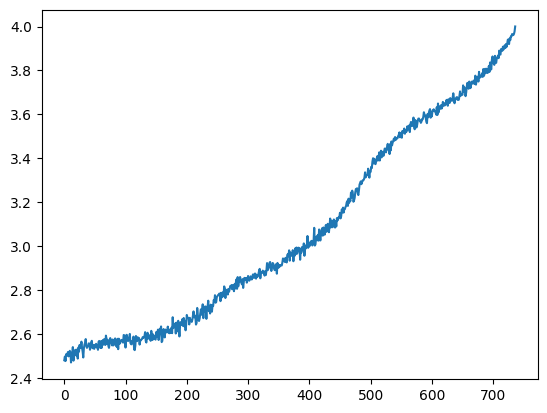

In [65]:
# print(np.median(result_dict))
# print(np.median(result_box))
# print(np.median(result_array_736))
plt.plot(result_array_736)